# All BP showcase

This notebook shows how all currently supported Belief Propagation Solvers can be used out of the box for a toy scenario.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import torch_bp.bp as bp
import torch_bp.graph.factors as factors
import torch_bp.distributions as dist
from torch_bp.graph.mrf_graph import edge_n_factor_to_mrf_graph
from torch_bp.graph.factor_graph import FactorGraph
from torch_bp.inference.kernels import RBFMedianKernel

from torch_bp.util.plotting import plot_graph, plot_dists, plot_particles

Consider a multi-agent/part localization problem.
Of 9 agents, 8 of them have multi-modal estimate of their true position, while 1 agent does not have any information (other than it is within the defined map).
Agents are aware of the distance between known pairs of neighbours (1m).

The following code defines this relationship as a Markov Random Field.

In [3]:
N = 9
SIGMA = 0.05
PAIR_ALPHA = 1

LIMS = [0, 4, 0, 4]
nodes = [(i,) for i in range(N)]
edges = [(0, 1), (1, 2),
         (1, 4),
         (3, 4), (4, 5),
         (4, 7),
         (6, 7), (7, 8)]

node_pos = np.array([[j, i] for i in range(1, 4) for j in range(1, 4)])
node_obs = [dist.Mixture([node_pos[i, :] + 0.25, node_pos[i, :] - 0.25], [SIGMA * torch.eye(2), SIGMA * torch.eye(2)]) \
                 for i in range(N)]
node_obs[4] = dist.SmoothUniform([0, 0], [4, 4])  # The middle has no observation.

unary_factors = [factors.DistributionUnaryFactor(node_obs[i]) for i in range(N)]
edge_factors = [factors.DistancePairwiseFactor(1, alpha=PAIR_ALPHA) for _ in edges]

mrf_graph = edge_n_factor_to_mrf_graph(N, nodes+edges, unary_factors+edge_factors)

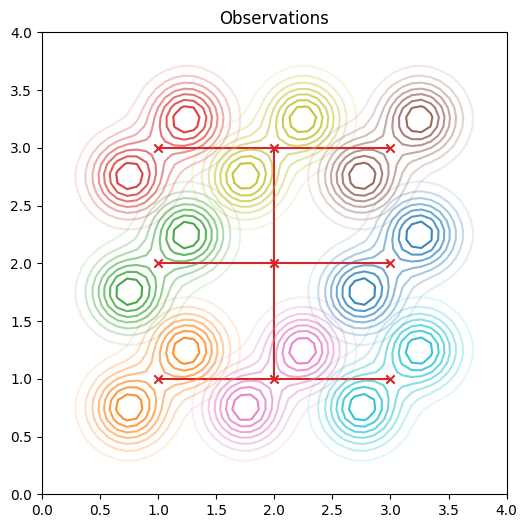

In [4]:
N_PIX = 45
CELL_SIZE = (LIMS[1] - LIMS[0]) / (N_PIX - 1)
x = np.linspace(*LIMS[:2], N_PIX)
y = np.linspace(*LIMS[2:], N_PIX)

X, Y = np.meshgrid(x, y)
vals = np.stack([X.reshape(-1), Y.reshape(-1)], axis=-1)
vals = torch.as_tensor(vals, dtype=torch.float32, device="cpu")

fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Observations")
plot_graph(ax, node_pos, mrf_graph)
plot_dists(ax, node_obs, LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Discrete BP

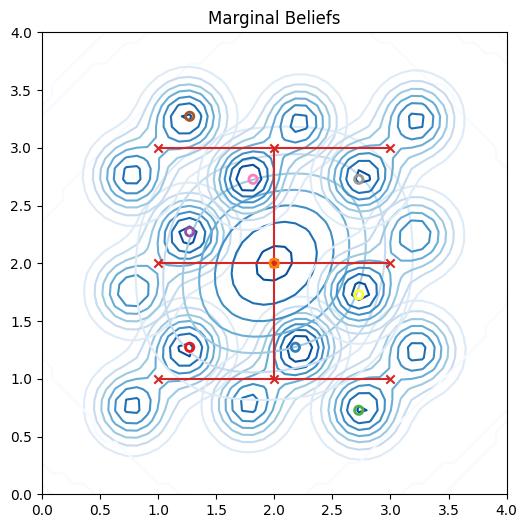

In [5]:
discrete_bp = bp.DiscreteBP(node_vals=vals, graph=mrf_graph)
bel_distb = discrete_bp.solve()


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Marginal Beliefs")
cmap = mpl.colormaps['Set1']

# Draw beliefs.
mles = []
# for bel in discrete_bp.get_beliefs():
for i, bel in enumerate(bel_distb):
    bel = bel.view(N_PIX, N_PIX)
    plt.contour(X, Y, bel, cmap="Blues", zorder=2)

    best_idx = (bel == bel.max()).nonzero()
    best_i, best_j = best_idx[0, 0], best_idx[0, 1]
    best_x, best_y = X[best_i, best_j], Y[best_i, best_j]
    plt.scatter(best_x, best_y, marker='o',
                edgecolors=cmap(i), facecolors='none', linewidths=2, zorder=3)
    mles.append([best_x, best_y])

plot_graph(ax, node_pos, mrf_graph)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Particle BP

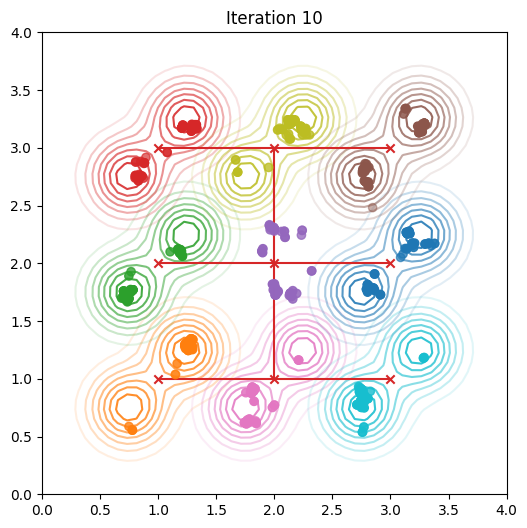

In [6]:
K = 50            # num of particles per node
INIT_SIGMA = 0.1  # spread of particles

ITER = 10         # number of iteration to make particles converge
JITTER = 0.01     # To jitter particles between iterations

sig = INIT_SIGMA * torch.eye(2, dtype=torch.float32)
init_particles = torch.stack([dist.Gaussian(node_pos[i, :], sig).sample(K) for i in range(N)])

particle_bp = bp.ParticleBP(init_particles=init_particles, graph=mrf_graph,
                            sample_mode="nodes", lims=LIMS)
particles, weights = particle_bp.solve(num_iters=ITER, jitter_sigma=JITTER, return_weights=True)

# Draw the particles
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Iteration {ITER}")
plot_particles(ax, particles, node_pos=node_pos, graph=mrf_graph, dists=node_obs, weights=weights, lims=LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Loopy Particle BP

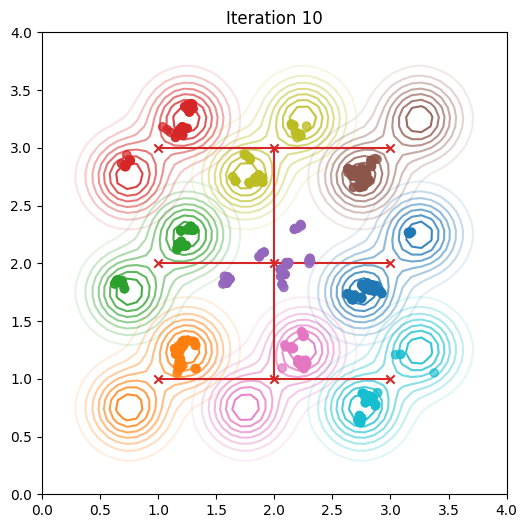

In [7]:
K = 50            # num of particles per node
INIT_SIGMA = 0.1  # spread of particles

ITER = 10              # number of iteration to make particles converge
MSG_PASS_PER_ITER = 5  # number of message passing cycles per iteration
JITTER = 0.01          # To jitter particles between iterations

sig = INIT_SIGMA * torch.eye(2, dtype=torch.float32)
init_particles = torch.stack([dist.Gaussian(node_pos[i, :], sig).sample(K) for i in range(N)])

loopy_pbp = bp.LoopyParticleBP(init_particles=init_particles, graph=mrf_graph,
                               msg_init_mode="uniform")
particles, weights = loopy_pbp.solve(num_iters=ITER, msg_pass_per_iter=MSG_PASS_PER_ITER,
                                     jitter_sigma=JITTER, return_weights=True)

# Draw the particles
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Iteration {ITER}")
plot_particles(ax, particles, node_pos=node_pos, graph=mrf_graph, dists=node_obs, weights=weights, lims=LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Stein BP

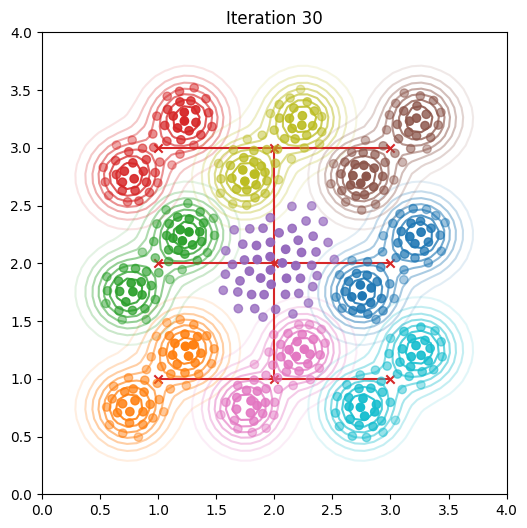

In [8]:
K = 50            # num of particles per node
INIT_SIGMA = 0.1  # spread of particles

ITER = 30         # number of iteration to make particles converge

rbf_kernel = RBFMedianKernel(sigma=0.05)  # kernel to use
optim_type = torch.optim.Adam             # optimizer type
optim_hyperparams = {'lr':0.1}            # optimizer params

sig = INIT_SIGMA * torch.eye(2, dtype=torch.float32)
init_particles = torch.stack([dist.Gaussian(node_pos[i, :], sig).sample(K) for i in range(N)])

stein_bp = bp.SVBP(particles=init_particles, graph=mrf_graph,
                   kernel=rbf_kernel,
                   optim_type=optim_type, optim_kwargs=optim_hyperparams)
particles, weights = stein_bp.solve(num_iters=ITER, return_weights=True)

# Draw the particles
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Iteration {ITER}")
plot_particles(ax, particles, node_pos=node_pos, graph=mrf_graph, dists=node_obs, weights=weights, lims=LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Loopy Stein BP

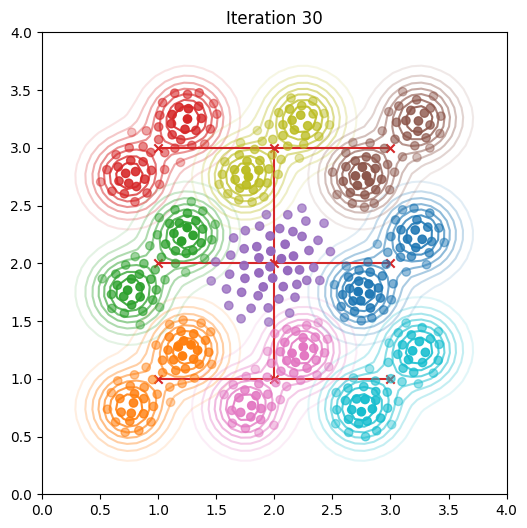

In [9]:
K = 50            # num of particles per node
INIT_SIGMA = 0.1  # spread of particles

ITER = 30              # number of iteration to make particles converge
MSG_PASS_PER_ITER = 5  # number of message passing cycles per iteration

rbf_kernel = RBFMedianKernel(sigma=0.05) # kernel to use
optim_type = torch.optim.Adam # optimizer type
optim_hyperparams = {'lr':0.1} # optimizer params

sig = INIT_SIGMA * torch.eye(2, dtype=torch.float32)
init_particles = torch.stack([dist.Gaussian(node_pos[i, :], sig).sample(K) for i in range(N)])

loopy_sbp = bp.LoopySVBP(particles=init_particles, graph=mrf_graph,
                         kernel=rbf_kernel,
                         optim_type=optim_type, optim_kwargs=optim_hyperparams,
                         msg_init_mode="uniform", optimize=True)
particles, weights = loopy_sbp.solve(num_iters=ITER, msg_pass_per_iter=MSG_PASS_PER_ITER, return_weights=True)

# Draw the particles
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Iteration {ITER}")
plot_particles(ax, particles, node_pos=node_pos, graph=mrf_graph, dists=node_obs, weights=weights, lims=LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Linear Gaussian BP

Gaussian Belief Propagation represents (single modal) Gaussian beliefs and observations very naturally.
Hence the scenario is updated to use Gaussian distributions instead.

For the Gaussian BP algorithm, our implementation is heavily based off: https://gaussianbp.github.io/.
Hence, it uses a `FactorGraph` representation instead of an `MRFGraph` representation on the backend and a unique factor representation.

Note: Multi-modal distributions might be representatble by linearizing the factors consistently about a defined linearization point. We support the definition of nonlinear factors Gaussian Factors and these would be periodically linearized. (See `pairwise_dist_factors` below and note `False` flag). 

In [10]:
from torch_bp.graph.factors.linear_gaussian_factors import UnaryGaussianLinearFactor, PairwiseGaussianLinearFactor

SIGMA = 0.05 # observation variance
tensor_kwargs={'device': 'cpu', 'dtype': torch.float64} # default uses float64 due to inversion ops

# updated graph
nodes = [(i,) for i in range(N) if i != 4]
node_obs = [dist.Gaussian(node_pos[i, :], SIGMA * torch.eye(2)) for i in nodes]

# define functions to get the mean

def unary_anchor_fn(x: torch.Tensor):
    batch_shape = x.shape[:-1]
    grad = torch.eye(x.shape[-1], dtype=x.dtype).repeat(batch_shape+(1,1))
    return grad, x

def pairwise_dist_fn(x: torch.Tensor):
    h_fn = lambda x: torch.linalg.norm(x[:2] - x[2:])
    grad_fn = torch.func.jacrev(h_fn)
    return grad_fn(x)[None,:], h_fn(x)

init_mu = torch.randn(9, 2) * 2 + 2
init_covar = torch.eye(2).repeat(9,1,1) * 2
unary_anchor_factors = [UnaryGaussianLinearFactor(unary_anchor_fn,
                                                  torch.as_tensor(node_pos[i]).to(**tensor_kwargs),
                                                  SIGMA * torch.eye(2, **tensor_kwargs),
                                                  init_mu[i].to(**tensor_kwargs),
                                                  True)
                        for i in nodes]
pairwise_dist_factors = [PairwiseGaussianLinearFactor(pairwise_dist_fn,
                                                      1.0 * torch.ones(1).to(**tensor_kwargs),
                                                      2 * SIGMA * torch.eye(1, **tensor_kwargs),
                                                      torch.concat((init_mu[i], init_mu[j]), dim=-1).to(**tensor_kwargs),
                                                      False)
                        for i,j in edges]

factor_graph = FactorGraph(num_nodes=N,
                           factors=unary_anchor_factors+pairwise_dist_factors,
                           factor_neighbours=nodes+edges)

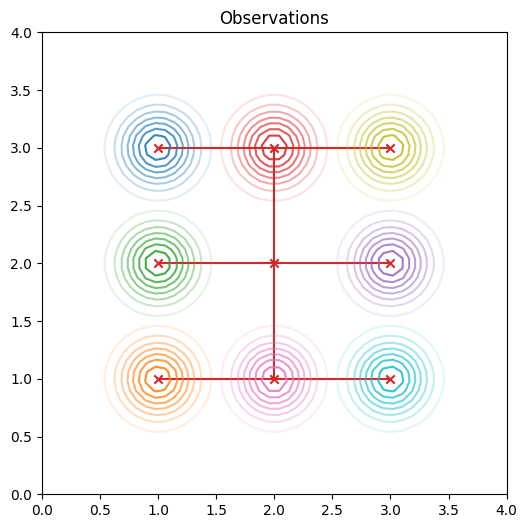

In [11]:
N_PIX = 100
CELL_SIZE = (LIMS[1] - LIMS[0]) / (N_PIX - 1)
x = np.linspace(*LIMS[:2], N_PIX)
y = np.linspace(*LIMS[2:], N_PIX)

X, Y = np.meshgrid(x, y)
vals = np.stack([X.reshape(-1), Y.reshape(-1)], axis=-1)
vals = torch.as_tensor(vals, dtype=torch.float32, device="cpu")

fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Observations")
plot_graph(ax, node_pos, factor_graph)
plot_dists(ax, node_obs, LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

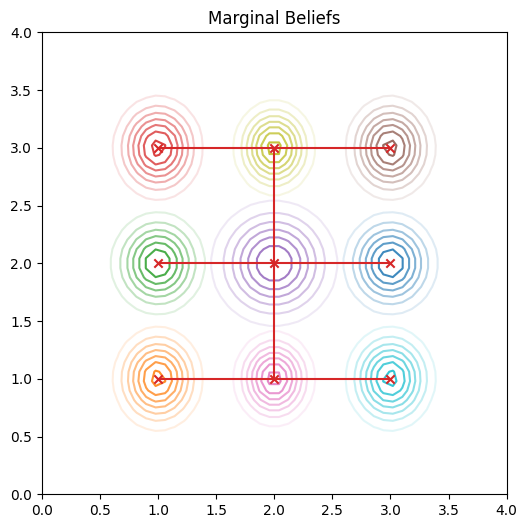

In [12]:
ITER = 10  # number of iteration to make particles converge

linear_gabp = bp.LinearGaussianBP(node_means=init_mu, node_covars=init_covar,
                                  factor_graph=factor_graph,
                                  tensor_kwargs=tensor_kwargs)
means, covars = linear_gabp.solve(num_iters=ITER)

# plot surface
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Marginal Beliefs")
bel_distbs = [dist.Gaussian(mu, sigma, **tensor_kwargs) for mu, sigma in zip(means, covars)]
plot_dists(ax, bel_distbs, lims=LIMS)

plot_graph(ax, node_pos, factor_graph)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);


## Loopy Gaussian BP

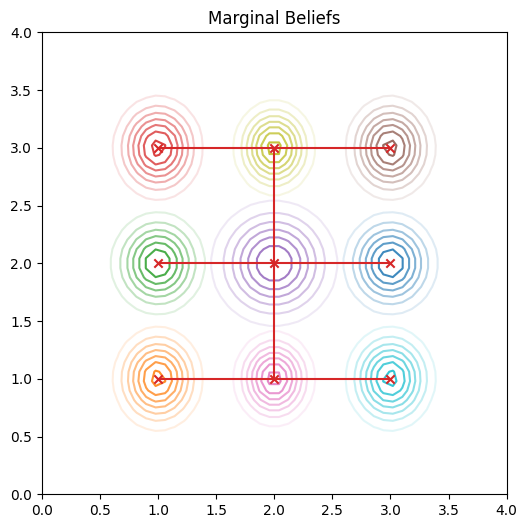

In [13]:
INIT_SIGMA = 0.1       # observed spread of particles
ITER = 10              # number of iteration to make particles converge
MSG_PASS_PER_ITER = 5  # number of message passing cycles per iteration (or number of msg passing before 1 linearization)

loopy_gabp = bp.LoopyLinearGaussianBP(node_means=init_mu, node_covars=init_covar,
                                      factor_graph=factor_graph,
                                      tensor_kwargs=tensor_kwargs)
means, covars = loopy_gabp.solve(num_iters=ITER, msg_pass_per_iter=MSG_PASS_PER_ITER)

# plot surface
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Marginal Beliefs")
bel_distbs = [dist.Gaussian(mu, sigma, **tensor_kwargs) for mu, sigma in zip(means, covars)]
plot_dists(ax, bel_distbs, lims=LIMS)

plot_graph(ax, node_pos, factor_graph)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);